In [1]:
import sys
from os.path import isfile

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.signal import savgol_filter

import scipy
from scipy import stats as st
from scipy import optimize as opt

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras import callbacks
from tensorflow_addons.metrics import F1Score

# My packages
sys.path.insert(0, "../scs/")
import data_degrading as dd
import data_preparation as dp
import data_augmentation as da
from prepare_datasets_for_training import extract
import data_plotting as dplt
import scs_config

sys.path.insert(0, "../scs/models/")
import feed_forward
import transformer_encoder

from icecream import ic

import snr_test

from importlib import reload

In [2]:
rng = np.random.RandomState(1415)
overwrite = True

In [3]:
def load_original_dataset():
    ic()
    file_df_raw = "../data/raw/sn_data.parquet"
    df_raw = pd.read_parquet(file_df_raw)
    return df_raw

df_raw = load_original_dataset()

ic| 1771033265.py:2 in load_original_dataset() at 17:11:14.023


In [21]:
df_raw.std(axis=1).shape

/tmp/ipykernel_37779/1776287760.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_raw.std(axis=1).shape


(5001,)

(<Figure size 1152x576 with 1 Axes>,
 <AxesSubplot:xlabel='Wavelength [$\\AA$]', ylabel='Normalized Flux [$F_{\\lambda}$]'>)

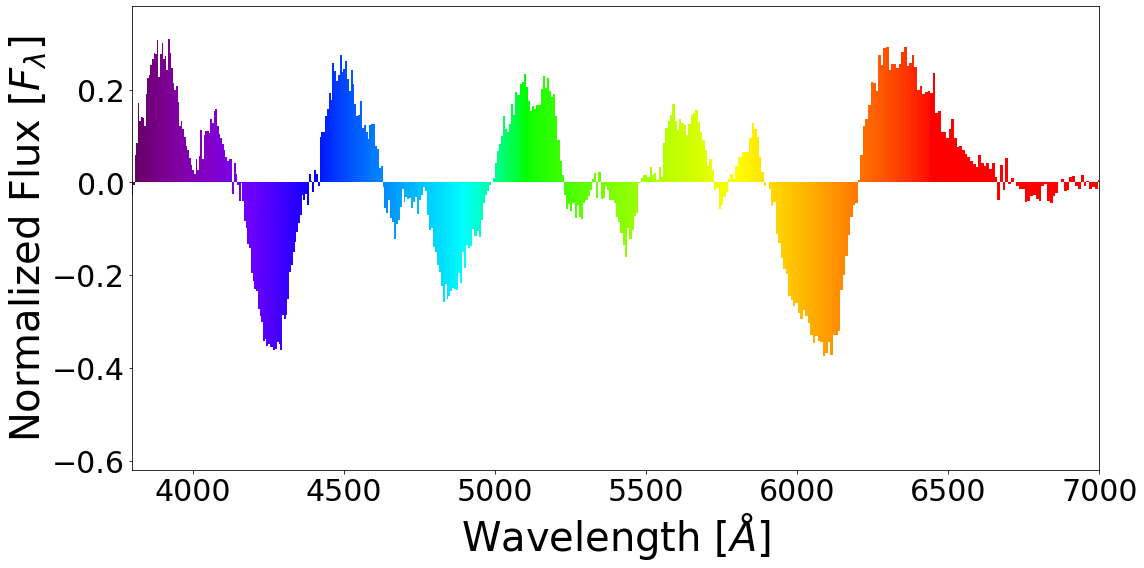

In [4]:
index, wvl, flux_columns, metadata_columns, df_fluxes, df_metadata, fluxes = dp.extract_dataframe(df_raw)
dplt.plot_spec(wvl, fluxes[0])

In [5]:
noise_scale = 10000

def load_noise():
    ic()
    file_df_noise = "../data/raw/sn_noise.parquet"
    df_noise = pd.read_parquet(file_df_noise)
    return df_noise

df_noise = load_noise()
data = dp.extract_dataframe(df_noise)
_, _, flux_columns, _, _, _, noise = data
df_raw[flux_columns] += (noise_scale - 1) * noise

ic| 3190231364.py:4 in load_noise() at 17:11:15.966


In [6]:
df_raw = df_noise.copy(deep=True)

In [7]:
# Replace data with completely random noise
from scipy import stats
df_raw[flux_columns] = stats.uniform.rvs(loc=-1, scale=2, size=noise.shape)

(<Figure size 1152x576 with 1 Axes>,
 <AxesSubplot:xlabel='Wavelength [$\\AA$]', ylabel='Normalized Flux [$F_{\\lambda}$]'>)

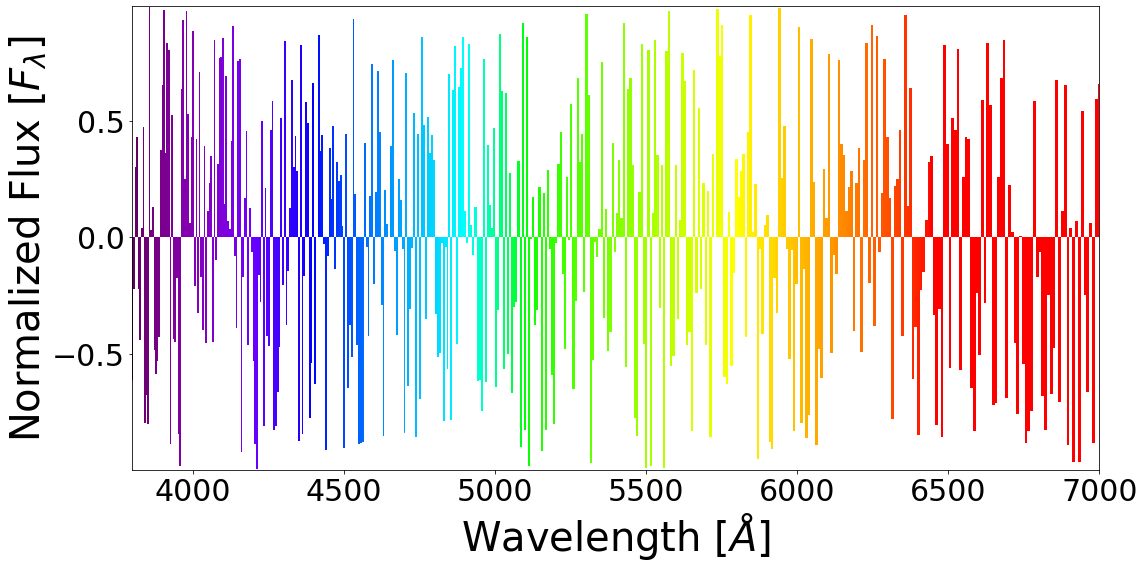

In [8]:
index, wvl, flux_columns, metadata_columns, df_fluxes, df_metadata, fluxes = dp.extract_dataframe(df_raw)
dplt.plot_spec(wvl, fluxes[0])

In [9]:
def normalize_data(df):
    """
    I don't know if I should be doing this, but when you add to much noise things get insane so I need to do this as a stopgap to make the rest of the code work.
    """
    
    df_normed = df.copy(deep=True)
    
    index, wvl, flux_columns, metadata_columns, df_fluxes, df_metadata, fluxes = dp.extract_dataframe(df)
    fluxes_mean = np.nanmean(fluxes, axis=1)[:, None]
    
    df_normed[flux_columns] = fluxes - fluxes_mean
    return df_normed
    
df_raw = normalize_data(df_raw)
df_raw.dropna(axis=0, inplace=True)

df_raw.isna().sum().sum()

0

In [10]:
# def degrade_data(df_raw, R):
#     ic()
#     df_C, df_R = dd.degrade_dataframe(R, df_raw)
#     return df_C, df_R

# R = 100
# df_C, df_R = degrade_data(df_raw, R)

df_C, df_R = df_raw.copy(deep=True), df_raw.copy(deep=True)

df_C.isna().sum().sum(), df_R.isna().sum().sum()

(0, 0)

In [11]:
def clean_data(df_C, df_R, phase_range, ptp_range, wvl_range):
    ic()
    df_CP = dp.preproccess_dataframe(
        df_C,
        phase_range=phase_range,
        ptp_range=ptp_range,
        wvl_range=wvl_range,
    )
    df_RP = dp.preproccess_dataframe(
        df_R,
        phase_range=phase_range,
        ptp_range=ptp_range,
        wvl_range=wvl_range,
    )
    return df_CP, df_RP

phase_range = (-20, 50)
ptp_range = (0.1, 100)
ptp_range = (-np.inf, np.inf)
wvl_range = (4500, 7000)
df_CP, df_RP = clean_data(df_C, df_R, phase_range, ptp_range, wvl_range)

df_CP.isna().sum().sum(), df_RP.isna().sum().sum()

ic| 3915160529.py:2 in clean_data() at 17:11:26.903


(0, 0)

In [12]:
df_CP.dropna(axis=0, inplace=True)
df_RP.dropna(axis=0, inplace=True)

/tmp/ipykernel_37779/3077339788.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CP.dropna(axis=0, inplace=True)
/tmp/ipykernel_37779/3077339788.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RP.dropna(axis=0, inplace=True)


In [13]:
df_CP.isna().sum().sum(), df_RP.isna().sum().sum()

(0, 0)

In [14]:
reload(dp)

def split_train_test(df_CP, df_RP, train_frac, rng):
    ic()
    df_CP_trn, df_CP_tst = dp.split_data(df_CP, train_frac, rng)
    df_RP_trn, df_RP_tst = dp.split_data(df_RP, train_frac, rng)
    return df_CP_trn, df_CP_tst, df_RP_trn, df_RP_tst

train_frac = 0.60
df_CP_trn, df_CP_tst, df_RP_trn, df_RP_tst = split_train_test(
    df_CP, df_RP, train_frac, rng
)

ic| 2765672014.py:4 in split_train_test() at 17:11:28.933


In [15]:
reload(da)

def augment_training_set(df_CP_trn, df_RP_trn, rng, wvl_range, spike_scale, max_spikes):
    ic()
    df_CPA_trn = da.augment(
        df_CP_trn,
        rng,
        wvl_range=wvl_range,
        noise_scale=0,
        spike_scale=spike_scale,
        max_spikes=max_spikes,
    )
    df_RPA_trn = da.augment(
        df_RP_trn,
        rng,
        wvl_range=wvl_range,
        noise_scale=0,
        spike_scale=spike_scale,
        max_spikes=max_spikes,
    )
    return df_CPA_trn, df_RPA_trn


spike_scale = 3
max_spikes = 5
df_CPA_trn, df_RPA_trn = augment_training_set(
    df_CP_trn, df_RP_trn, rng, wvl_range, spike_scale, max_spikes
)

ic| 2267896975.py:4 in augment_training_set() at 17:11:29.072


In [16]:
Xtrn, Ytrn, num_trn, num_wvl, num_classes = extract(df_CPA_trn)
Xtst, Ytst, num_tst, num_wvl, num_classes = extract(df_CP_tst)

(<Figure size 1152x576 with 1 Axes>,
 <AxesSubplot:xlabel='Wavelength [$\\AA$]', ylabel='Normalized Flux [$F_{\\lambda}$]'>)

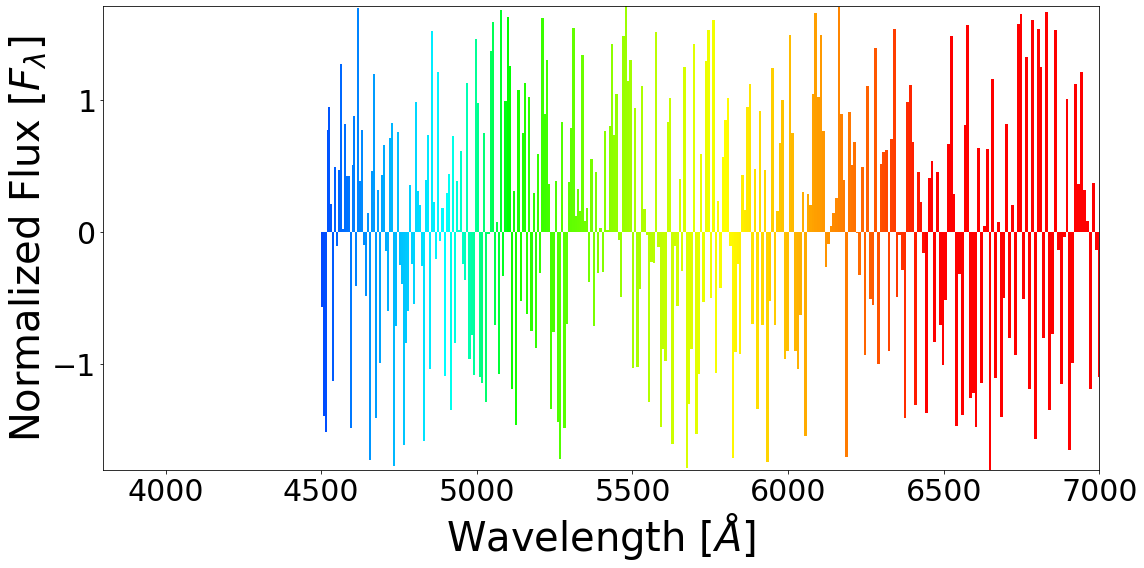

In [17]:
dplt.plot_spec(wvl, Xtrn[0])

In [18]:
def get_model(input_shape, num_classes):
    ic()
    model = feed_forward.model(
        input_shape,
        num_classes,
        [1024, 1024, 1024],
        activation="relu",
        dropout=0.5,
    )
    return model

input_shape = Xtrn.shape[1:]
model = get_model(input_shape, num_classes)
model.summary()

lr0 = 1e-5
loss = CategoricalCrossentropy()
acc = CategoricalAccuracy(name="ca")
f1 = F1Score(num_classes=num_classes, average="macro", name="f1")
opt = Nadam(learning_rate=lr0)
model.compile(loss=loss, optimizer=opt, metrics=[acc, f1])

early = callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=2,
    mode="min",
    restore_best_weights=True,
)
file_log = f"../data/snr_test/{noise_scale}_history.log"
logger = callbacks.CSVLogger(file_log, append=False)
cbs = [early, logger]

history = model.fit(
    Xtrn,
    Ytrn,
    validation_data=(Xtst, Ytst),
    epochs=10_000,
    batch_size=32,
    verbose=2,
    callbacks=cbs,
)

loss_trn, ca_trn, f1_trn = model.evaluate(x=Xtrn, y=Ytrn, verbose=0)
loss_tst, ca_tst, f1_tst = model.evaluate(x=Xtst, y=Ytst, verbose=0)

results = f"{noise_scale},{loss_trn},{ca_trn},{f1_trn},{loss_tst},{ca_tst},{f1_tst}\n"
ic(results)

ic| 2140965539.py:2 in get_model() at 17:11:49.644


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0     

2023-12-06 17:11:49.667396: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/shared/slurm/lib:/lustre/lrspec/users/2649/anaconda3/envs/fox/lib/:/lustre/lrspec/users/2649/anaconda3/envs/fox/lib/
2023-12-06 17:11:49.667457: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-06 17:11:49.667495: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (r1n00): /proc/driver/nvidia/version does not exist
2023-12-06 17:11:49.667742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appro

Epoch 1/10000
635/635 - 15s - loss: 2.8606 - ca: 0.0946 - f1: 0.0952 - val_loss: 2.7774 - val_ca: 0.0524 - val_f1: 0.0335 - 15s/epoch - 23ms/step
Epoch 2/10000
635/635 - 13s - loss: 2.5954 - ca: 0.1975 - f1: 0.1896 - val_loss: 2.7705 - val_ca: 0.0454 - val_f1: 0.0325 - 13s/epoch - 20ms/step
Epoch 3/10000
635/635 - 13s - loss: 2.3603 - ca: 0.2917 - f1: 0.2723 - val_loss: 2.7185 - val_ca: 0.0594 - val_f1: 0.0397 - 13s/epoch - 20ms/step
Epoch 4/10000
635/635 - 13s - loss: 2.1475 - ca: 0.3540 - f1: 0.3327 - val_loss: 2.7172 - val_ca: 0.0415 - val_f1: 0.0284 - 13s/epoch - 20ms/step
Epoch 5/10000
635/635 - 13s - loss: 1.9609 - ca: 0.3988 - f1: 0.3807 - val_loss: 2.6632 - val_ca: 0.0473 - val_f1: 0.0326 - 13s/epoch - 20ms/step
Epoch 6/10000
635/635 - 13s - loss: 1.8209 - ca: 0.4294 - f1: 0.4135 - val_loss: 2.5910 - val_ca: 0.0556 - val_f1: 0.0314 - 13s/epoch - 21ms/step
Epoch 7/10000
635/635 - 13s - loss: 1.7110 - ca: 0.4496 - f1: 0.4379 - val_loss: 2.5963 - val_ca: 0.0511 - val_f1: 0.0314 - 

ic| results: '10000,0.9490422606468201,0.8156482577323914,0.7931963801383972,2.483581066131592,0.056869011372327805,0.033375006169080734
              '


'10000,0.9490422606468201,0.8156482577323914,0.7931963801383972,2.483581066131592,0.056869011372327805,0.033375006169080734\n'

In [19]:
Ytrn_flat = np.argmax(Ytrn, axis=1)
Ytrn_flat.shape

(20309,)

49/49 [==============================] - 0s 3ms/step


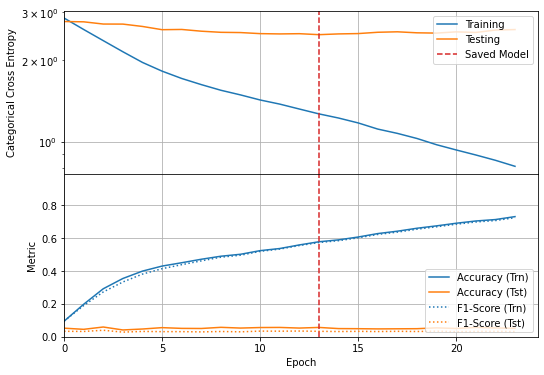

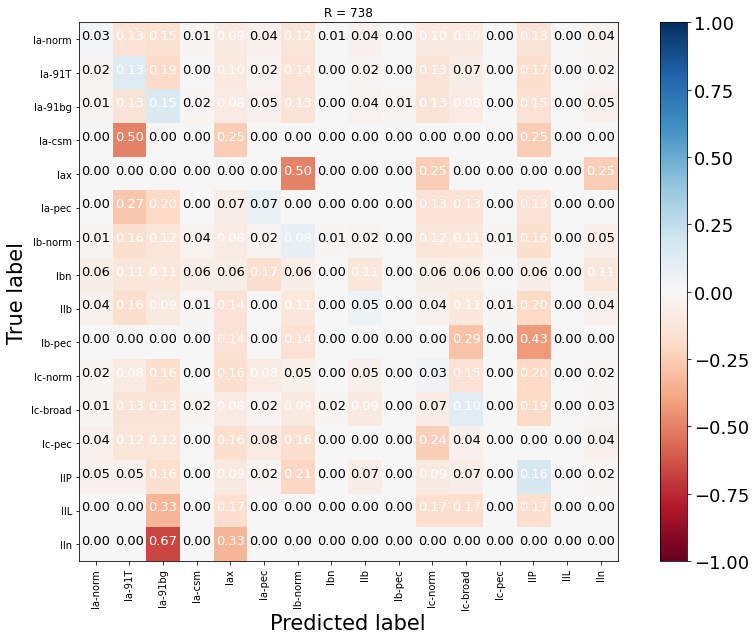

In [20]:
# Analysis

log = pd.read_csv(file_log)

## Loss curves

fig = dplt.plot_loss(log, scale=6)
fig.show()

## Confusion Matrix

SNtypes_int = np.unique(Ytrn_flat)
SNtypes_str = [scs_config.SN_Stypes_int_to_str[sn] for sn in SNtypes_int]

Ptst = model.predict(Xtst)
Ptst_flat = np.argmax(Ptst, axis=1)
Ytst_flat = np.argmax(Ytst, axis=1)

CMtst = confusion_matrix(Ytst_flat, Ptst_flat)
dplt.plot_cm(CMtst, SNtypes_str, 738, normalize=True)